<a href="https://colab.research.google.com/github/deepu718/tensorflow_practice/blob/main/04_transfer_learning_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 1: Feature Extraction

Transfer Learning is leveraging a workin model existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture prove to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, rthen we can adapt those patterns to our own data.


## Download and becoming one with data

In [1]:
# get data
import zipfile

# download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-08-06 16:45:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 108.177.11.128, 173.194.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   143MB/s    in 1.1s    

2023-08-06 16:45:37 (143 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder
import os

# walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` to load in our images in batches.

In [14]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images
Found 750 images belonging to 10 classes.
Testing images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback



In [21]:
 # Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorflow log files to : {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we've used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layer are going to come from Tensorflow Hub.

We can access pretrained models on: https://tfhub/.dev/

Browsing the Tensorflow Hub page and sorting for image classification we found following feature vecor model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [34]:
# Let's Compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [23]:
 # Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [24]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a Tensorflow Hub URL and create a Keras Sequential model with it.

  Args:
    model_url (str): A tensorflow hub feature extraction url.
    num_classes (int): Number of output neuron in the output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE + (3,)) # freeze the already learned patterns

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## Creating ResNet Tensorflow Hub Feature Extraction model

In [25]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [26]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [27]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [28]:
# Let's fit our ResNet model to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                 steps_per_epoch=len(train_data_10_percent),
                 epochs=5,
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet50V2")])

Saving Tensorflow log files to : tensorflow_hub/resnet50V2/20230806-173856
Epoch 1/5
24/24 [==============================] - 28s 569ms/step - loss: 1.9344 - accuracy: 0.3573 - val_loss: 1.2247 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 11s 480ms/step - loss: 0.9184 - accuracy: 0.7413 - val_loss: 0.8526 - val_accuracy: 0.7252
Epoch 3/5
24/24 [==============================] - 11s 481ms/step - loss: 0.6434 - accuracy: 0.8187 - val_loss: 0.7437 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 11s 483ms/step - loss: 0.4877 - accuracy: 0.8720 - val_loss: 0.6927 - val_accuracy: 0.7700
Epoch 5/5
24/24 [==============================] - 11s 481ms/step - loss: 0.3848 - accuracy: 0.9173 - val_loss: 0.6658 - val_accuracy: 0.7732


In [31]:
# Let's create a funtion to plot our loss curves..
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """

  Returns separate loss curves for training and validation metrics.

  Args:
    history: Tensorflow history object.

  Returns:
    Plots of training/validation loss and accuracy metrics.

  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss,label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy,label="training_acc")
  plt.plot(epochs, val_accuracy, label="val_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();



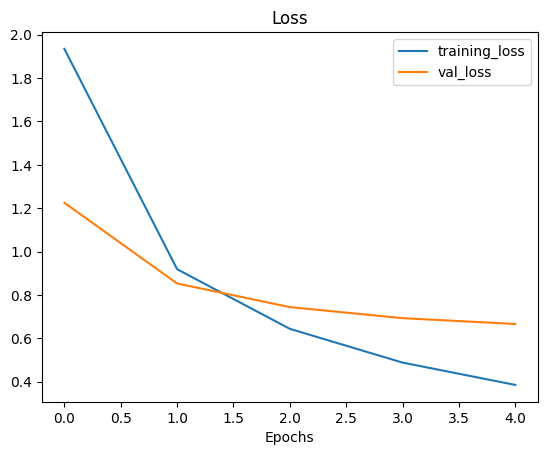

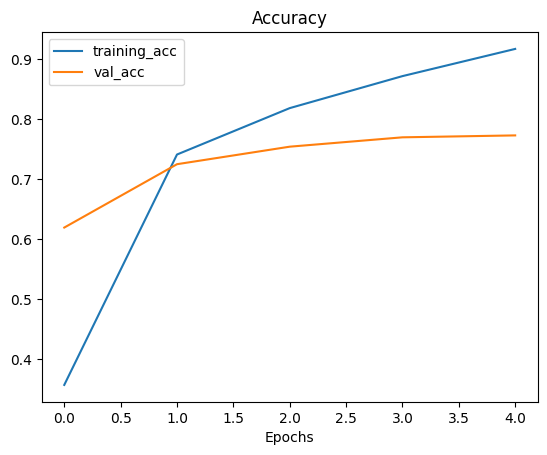

In [32]:
plot_loss_curves(resnet_history)

## Creating and Testing EfficintNetB0 TensorFlow Hub Feature Extraction model

In [41]:
# create EfficientB0 model
efficientnet_model = create_model(efficientnet_url)

In [42]:
# compile model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [43]:
# Let's fit our efficientnet model to the data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                 steps_per_epoch=len(train_data_10_percent),
                 epochs=5,
                 validation_data=test_data_10_percent,
                 validation_steps=len(test_data_10_percent),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="efficientnetB0")])

Saving Tensorflow log files to : tensorflow_hub/efficientnetB0/20230806-180753
Epoch 1/5
24/24 [==============================] - 25s 597ms/step - loss: 1.8962 - accuracy: 0.4253 - val_loss: 1.3399 - val_accuracy: 0.6948
Epoch 2/5
24/24 [==============================] - 13s 544ms/step - loss: 1.0946 - accuracy: 0.7587 - val_loss: 0.8918 - val_accuracy: 0.8012
Epoch 3/5
24/24 [==============================] - 11s 454ms/step - loss: 0.7759 - accuracy: 0.8413 - val_loss: 0.7155 - val_accuracy: 0.8320
Epoch 4/5
24/24 [==============================] - 10s 445ms/step - loss: 0.6174 - accuracy: 0.8680 - val_loss: 0.6255 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 11s 453ms/step - loss: 0.5227 - accuracy: 0.8880 - val_loss: 0.5707 - val_accuracy: 0.8560


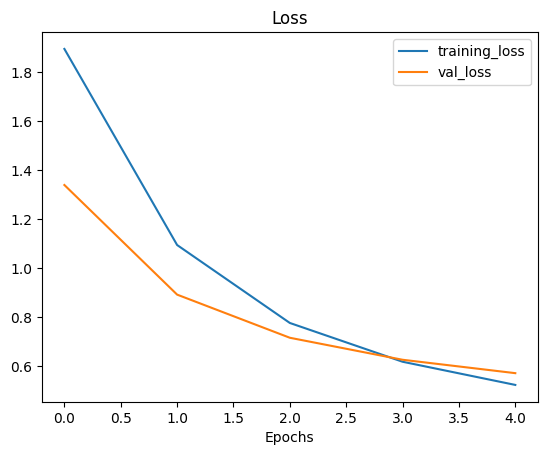

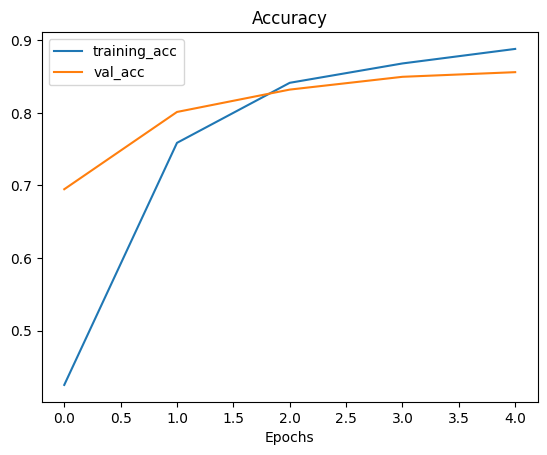

In [44]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* "As is" transfer learning - on an existing model with no changes what so over.
* "Feature Extraction" transfer learning - use the pretrained patterns of an existing model

In [ ]:
# Upload Tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 Vs. ResNet50V2" \
  --description "computing two different TF Hub feature extraction model architecture using 10% of the training data" \
  --one_shot

Our tensorboard experiments are uploaded publicly https://tensorboard.dev/experiment/qv6DkoikQPuGEGsvEedZIw/

In [48]:
# Check out what Tensorboard experiments you have
!tensorboard dev list

2023-08-06 18:36:04.595392: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/qv6DkoikQPuGEGsvEedZIw/
	Name                 EfficientNetB0 Vs. ResNet50V2
	Description          computing two different TF Hub feature extraction model architecture using 10% of the training data
	Id                   qv6DkoikQPuGEGsvEedZIw
	Created              2023-08-06 18:31:10 (4 minutes ago)
	Updated              2023-08-06 18:31:13 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5816974
Total: 1 experiment(s)
